- Follow https://www.kaggle.com/code/maartengr/topic-modeling-arxiv-abstract-with-bertopic/notebook
- Evaluation : https://github.com/MaartenGr/BERTopic/issues/90
- tips and tricks : https://maartengr.github.io/BERTopic/getting_started/tips_and_tricks/tips_and_tricks.html#keybert-bertopic
- break it down to each compoments : https://maartengr.github.io/BERTopic/algorithm/algorithm.html#code-overview

In [1]:
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context
import gensim
import pandas as pd
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer

/home/chuang/.conda/envs/sbert/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sentence_transformers import SentenceTransformer

### Pre compute embedings with selected models 

In [3]:
## load data 
docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']
## load model 
sentence_model = SentenceTransformer("all-distilroberta-v1")
## encode sentences 
embeddings = sentence_model.encode(docs, show_progress_bar=True)

Batches: 100%|██████████| 589/589 [05:18<00:00,  1.85it/s]


### Train topic model with precomputed embedings 

In [4]:
from umap import UMAP

In [5]:
## if you want to make it reproducable; set random state in umap to be fixed 
umap_model = UMAP(n_neighbors=15, n_components=5, 
                  min_dist=0, metric='cosine', random_state=42) #min_dist=0.05 to allow UMAP to place points closer together (the default value is 1.0)

## remove stop words when fingding keys for topic representation ; sbert will still use full sentence 
vectorizer_model = CountVectorizer(ngram_range=(1, 2),stop_words="english",min_df=10) ## set min number of word frequency, 

## initiate model 
## view all params https://maartengr.github.io/BERTopic/api/bertopic.html#bertopic._bertopic.BERTopic.__init__
model = BERTopic(language="English",
                top_n_words=10,
                min_topic_size=20,
                n_gram_range=(1, 2),
                nr_topics='auto',  ## number of topics you want to reduce to 
                #diversity=0.2, #
                #calculate_probabilities = True, # Whether to calculate the probabilities of all topics per document instead of the probability of the assigned topic per document. 
                verbose=False,
                umap_model=umap_model,
                vectorizer_model=vectorizer_model)

topics, probabilities = model.fit_transform(docs,embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [6]:
def prepare_docs_for_coherence_eval(docs,topics,probabilities):
    documents = pd.DataFrame({"Document": docs,
                          "ID": range(len(docs)),
                          "Topic": topics,
                          "Topic_prob": probabilities})
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    #print(documents_per_topic.head())
    # Extract vectorizer and analyzer from BERTopic
    vectorizer = model.vectorizer_model
    analyzer = vectorizer.build_analyzer()
    cleaned_docs = model._preprocess_text(documents_per_topic.Document.values)
    # Extract features for Topic Coherence evaluation
    words = vectorizer.get_feature_names()
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, _ in model.get_topic(topic) if words!=''] 
                for topic in range(len(set(topics))-1)]
    topic_words = [t for t in topic_words if len(t) >0] ## for some reason some topics has all "" as topic words

    return topic_words,tokens,corpus,dictionary

def get_coherence_score(topic_words,tokens,corpus,dictionary):
    # Evaluate
    coherence_model = CoherenceModel(topics=topic_words, 
                                    texts=tokens, 
                                    corpus=corpus,
                                    dictionary=dictionary, 
                                    coherence='c_v')
    coherence = coherence_model.get_coherence()
    
    return coherence

def eval_coherence_score(docs,topics,probabilities):
    topic_words,tokens,corpus,dictionary = prepare_docs_for_coherence_eval(docs,topics,probabilities)
    coherence = get_coherence_score(topic_words,tokens,corpus,dictionary)
    return coherence

In [7]:
#model.get_topic(7)
print("total number of topics: {}".format(len(model.get_topic_freq())))
print(model.get_topic_info().head())
model.visualize_barchart(top_n_topics=4, height=200)

total number of topics: 112
   Topic  Count                               Name
0     -1   7453              -1_god_like_know_just
1      0    823  0_disease_patients_medical_health
2      1    776              1_team_game_25_hockey
3      2    749           2_year_game_baseball_hit
4      3    718      3_key_encryption_clipper_chip


In [8]:
eval_score = eval_coherence_score(docs,topics,probabilities)
print("Coherence score: {}".format(eval_score))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

### Evaluate topic quality by human 
- https://maartengr.github.io/BERTopic/getting_started/visualization/visualization.html#visualize-topics


In [9]:
t_id = 2
sample_docs = model.get_representative_docs(topic=2)
print('topic keywords: {}'.format(model.get_topic(t_id)))
for d in sample_docs[:2]:
    print(d)

topic keywords: [('year', 0.01988501635184028), ('game', 0.019273817337871892), ('baseball', 0.017619841289459565), ('hit', 0.017033146648095968), ('team', 0.016470964521170056), ('players', 0.0149772140066536), ('games', 0.01424044441227468), ('pitching', 0.013433902238435444), ('runs', 0.012399875491527837), ('pitcher', 0.012282424903712407)]

Both protests would be denied, of course.  The umpire's judgement
determines the garbage thing, although I think the game should be
called (but that's my personal opinion...doesn't matter).  There
is time only when the ump says, so the second argument is baseless.



And you wrote an *excellent* report about it.




I understand (from an unreliable source) that Canseco was considered
expendable by the A's when he refused to accept any coaching about
his batting stance.  The A's brain trust came to believe that his
back problems were exacerbated, if not caused, by having a wide open
stance, closing it quickly and then swinging with a lot of torq

In [10]:
# Reduce dimensionality of embeddings, this step is optional
# reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

# Run the visualization with the original embeddings
#model.visualize_documents(docs[:10], embeddings=embeddings[:10])  ## can handle too many docs, need to sample some 

# Or, if you have reduced the original embeddings already:
#topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)

In [11]:
model.visualize_term_rank()

In [12]:
model.visualize_term_rank(log_scale=True)

In [13]:
model.visualize_topics(top_n_topics=50)

In [14]:
hierarchical_topics = model.hierarchical_topics(docs)
# Print topic tree
tree = model.get_topic_tree(hierarchical_topics)
print(tree)

100%|██████████| 110/110 [00:00<00:00, 160.12it/s]

.
├─people_government_think_don_key
│    ├─jesus_god_lord_jehovah_christ
│    │    ├─jehovah_elohim_mary_lord_god
│    │    │    ├─mary_marriage_priest_married_god
│    │    │    │    ├─■──marriage_married_marry_ceremony_marriages ── Topic: 91
│    │    │    │    └─■──mary_bernadette_maria_sin_priest ── Topic: 57
│    │    │    └─■──jehovah_elohim_lord_mcconkie_mormon ── Topic: 101
│    │    └─jesus_god_hell_matthew_bible
│    │         ├─hell_god_eternal_heaven_christ
│    │         │    ├─■──hell_eternal_heaven_god_jesus ── Topic: 58
│    │         │    └─■──god_faith_shall_christ_romans ── Topic: 48
│    │         └─jesus_matthew_prophecy_scripture_testament
│    │              ├─■──jesus_matthew_prophecy_messiah_prophecies ── Topic: 61
│    │              └─■──books_jesus_text_scripture_canon ── Topic: 38
│    └─people_government_key_think_don
│         ├─armenian_armenians_people_turkish_president
│         │    ├─homosexual_sex_gay_homosexuality_sexual
│         │    │    ├─■──ho

In [15]:
model.visualize_hierarchy(top_n_topics=50, width=600)

### Further Finetuning

- Find-tune topic keywords representation after training
- https://maartengr.github.io/BERTopic/getting_started/vectorizers/vectorizers.html#agglomerative-clustering

In [20]:
model.get_topic_info()[1:11]

,Topic,Count,Name
1,0,823,0_disease_patients_medical_health
2,1,776,1_team_game_25_hockey
3,2,749,2_year_game_baseball_hit
4,3,718,3_key_encryption_clipper_chip
5,4,588,4_israel_israeli_arab_jews
6,5,539,5_fbi_batf_koresh_compound
7,6,515,6____
8,7,224,7_sale_condition_audio_offer
9,8,211,8_car_engine_ford_cars
10,9,176,9_printer_print_hp_deskjet


### Use KeyBERT with BERTopic
- https://maartengr.github.io/BERTopic/getting_started/tips_and_tricks/tips_and_tricks.html#keybert-bertopic

In [22]:
from keybert import KeyBERT

In [35]:
# Extract keywords
kw_model = KeyBERT()
keywords = kw_model.extract_keywords(docs,stop_words='english')
# keywords = kw_model.extract_keywords(docs[:10],keyphrase_ngram_range=(1, 1), stop_words='english',
#                               use_mmr=True, diversity=0.7)

In [ ]:
# Create our vocabulary
vocabulary = [k[0] for keyword in keywords for k in keyword]
vocabulary = list(set(vocabulary))

# Use keywords vocabulary as vocabulary 
vectorizer_model= CountVectorizer(vocabulary=vocabulary,min_df=10)

key_model = BERTopic(language="English",
                top_n_words=10,
                min_topic_size=20,
                n_gram_range=(1, 3),
                nr_topics='auto',  ## number of topics you want to reduce to 
                #diversity=0.2, #
                #calculate_probabilities = True, # Whether to calculate the probabilities of all topics per document instead of the probability of the assigned topic per document. 
                verbose=False,
                umap_model=umap_model,
                vectorizer_model=vectorizer_model)

key_topics, key_probs = key_model.fit_transform(docs,embeddings)

In [ ]:
#model.get_topic(7)
print("total number of topics: {}".format(len(key_model.get_topic_freq())))
print(key_model.get_topic_info().head())
key_model.visualize_barchart(top_n_topics=4, height=200)

In [ ]:
eval_score = eval_coherence_score(docs,key_topics,key_probs)
print("Coherence score: {}".format(eval_score))

### Save and load model

In [16]:

model_out_path = '/data/chuang/temp/test_topic_model'
model.save(model_out_path, save_embedding_model=True)
loaded_model = BERTopic.load(model_out_path) # https://maartengr.github.io/BERTopic/api/bertopic.html#bertopic._bertopic.BERTopic.load


/home/chuang/.conda/envs/sbert/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [17]:
loaded_model.get_topic_info()

,Topic,Count,Name
0,-1,7453,-1_god_like_know_just
1,0,823,0_disease_patients_medical_health
2,1,776,1_team_game_25_hockey
3,2,749,2_year_game_baseball_hit
4,3,718,3_key_encryption_clipper_chip
...,...,...,...
107,106,24,106_monitor_problem_screen_610
108,107,23,107_hb_committee_sb_firearms
109,108,22,108_keyboard_pc_datadesk_key
110,109,22,109_faq_apoylis_inode_thanks


### Dig more into each components 

- First check with UMAP Dim Reduction 

In [37]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [41]:
## reuse the embedding from before 
print(embeddings.shape)
demo_embs = embeddings[:10000]
print(demo_embs.shape)

(18846, 768)
(10000, 768)


UMAP will attempt to preserve distances to the kth nearest point is what UMAP attempts to preserve when shifting to a lower dimension.
By increasing n_neighbors we can preserve more global structures, whereas a lower n_neighbors better preserves local structures.

UMAP can also be used as a supervised dimensionality reduction method by passing labels to the target argument if we have labeled data. It is possible to produce even more meaningful structures using this supervised approach.

100%|██████████| 9/9 [03:08<00:00, 20.94s/it]


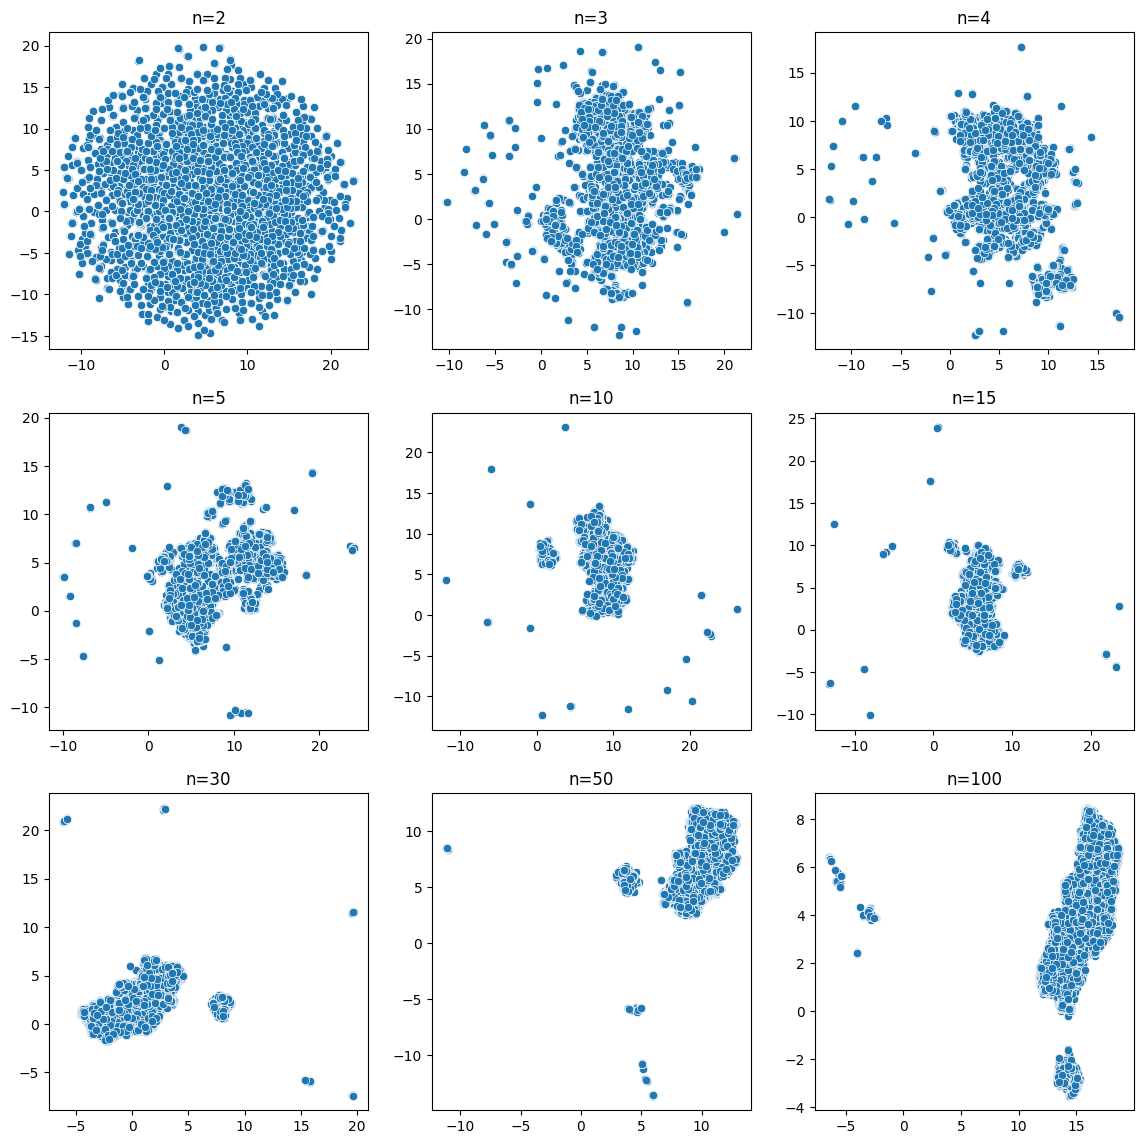

In [42]:
fig, ax = plt.subplots(3, 3, figsize=(14, 14))
nns = [2, 3, 4, 5, 10, 15, 30, 50, 100]
i, j = 0, 0
for n_neighbors in tqdm(nns):
    fit = umap.UMAP(n_neighbors=n_neighbors)
    u = fit.fit_transform(demo_embs)
    sns.scatterplot(x=u[:,0], y=u[:,1], ax=ax[j, i])
    ax[j, i].set_title(f'n={n_neighbors}')
    if i < 2: i += 1
    else: i = 0; j += 1

Using n_neighbors of 3-5 seems to work best. We can add min_dist=0.05 to allow UMAP to place points closer together (the default value is 1.0)

In [48]:
import plotly.express as px
import plotly

In [43]:
fit = umap.UMAP(n_neighbors=4, n_components=3, min_dist=0.05)
u = fit.fit_transform(demo_embs)

In [45]:
fig = px.scatter_3d(
    x=u[:,0], y=u[:,1], z=u[:,2],
    #color=data['sub'][:n],
    #custom_data=[data['sub'][:n], data['title'][:n]],
    #color_discrete_sequence=palette
)
# fig.update_traces(
#     hovertemplate="
# ".join([
#         "sub: %{customdata[1]}",
#         "title: %{customdata[0]}"
#     ])
# )
#fig.write_html("umap-topics-3d-color.html", include_plotlyjs="cdn", full_html=False)
fig

### Clustering with HDBSCAN
- https://hdbscan.readthedocs.io/en/latest/basic_hdbscan.html

<AxesSubplot: ylabel='$\\lambda$ value'>

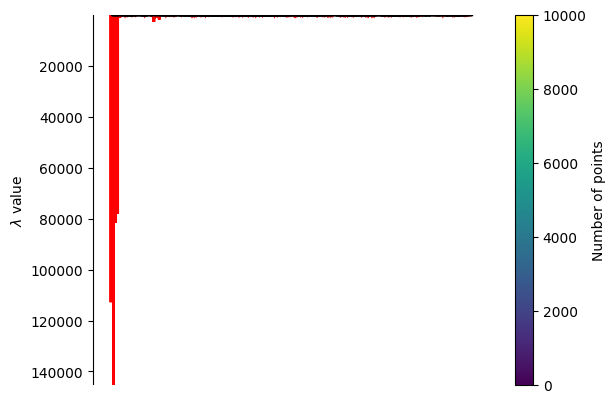

In [50]:
import hdbscan

clusterer = hdbscan.HDBSCAN()
clusterer.fit(u)
clusterer.condensed_tree_.plot(select_clusters=True)

<AxesSubplot: ylabel='$\\lambda$ value'>

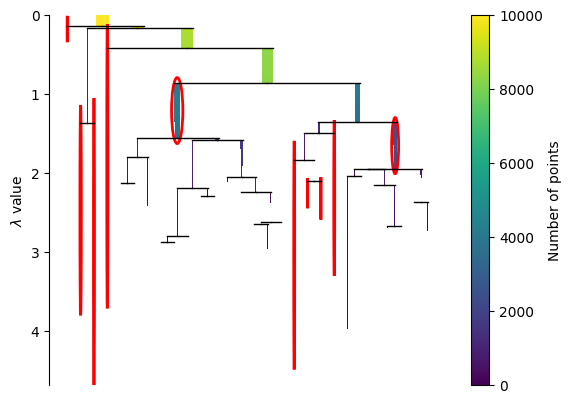

In [59]:
## change the min_cluster_size:minimun number of points in one cluster;  
## and min_samples: The number of samples in a neighbourhood for a point to be considered a core point.
## Steadily increasing min_samples will, as we saw in the examples above, make the clustering progressively more conservative

clusterer = hdbscan.HDBSCAN(min_cluster_size=80,min_samples=40)
clusterer.fit(u)
clusterer.condensed_tree_.plot(select_clusters=True)

In [60]:
colors = [str(x) for x in clusterer.labels_]

fig = px.scatter_3d(
    x=u[:,0], y=u[:,1], z=u[:,2],
    color=colors,
    #custom_data=[data['sub'][:n], data['title'][:n]],
    #color_discrete_sequence=palette
)
# fig.update_traces(
#     hovertemplate="
# ".join([
#         "sub: %{customdata[1]}",
#         "title: %{customdata[0]}"
#     ])
# )
fig

### Now put all components together

In [61]:
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
#from nltk.corpus import stopwords

In [63]:
umap_model = UMAP(n_neighbors=3, n_components=3, min_dist=0.05)
hdbscan_model = HDBSCAN(min_cluster_size=80, min_samples=40,
                        prediction_data=True, gen_min_span_tree=True)
#stopwords = list(stopwords.words('english')) + ['http', 'https', 'amp', 'com']
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")
# ## load data 
# docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']
# ## load model 
# sentence_model = SentenceTransformer("all-distilroberta-v1")
# ## encode sentences 
# embeddings = sentence_model.encode(docs, show_progress_bar=True)

In [64]:
model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    #embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words=5,
    language='english',
    calculate_probabilities=True,
    verbose=True
)
#model.fit(data['selftext'])
topics, probabilities = model.fit_transform(docs,embeddings)

2023-01-02 16:04:58,122 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-01-02 16:05:01,359 - BERTopic - Clustered reduced embeddings
